In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from selection_function import *
import sys
sys.path.append('../../mira_nsd_discovery/spectral_modelling/')
from spectral_modelling import *
model_grid = joint_grids(ext_law='Fritz')
model_grid_S = joint_grids(ext_law='Mine')


/home/jls/work/mira/mira_nsd/../../mira_nsd_discovery/spectral_modelling/spectral_modelling.py:221: RuntimeWarning: divide by zero encountered in log10
  np.log10(models['flux_wm2'].data.reshape(teff_number, tinner_number, odep_number,
/home/jls/work/mira/mira_nsd/../../mira_nsd_discovery/spectral_modelling/spectral_modelling.py:221: RuntimeWarning: divide by zero encountered in log10
  np.log10(models['flux_wm2'].data.reshape(teff_number, tinner_number, odep_number,
/home/jls/work/mira/mira_nsd/../../mira_nsd_discovery/spectral_modelling/spectral_modelling.py:221: RuntimeWarning: divide by zero encountered in log10
  np.log10(models['flux_wm2'].data.reshape(teff_number, tinner_number, odep_number,
/home/jls/work/mira/mira_nsd/../../mira_nsd_discovery/spectral_modelling/spectral_modelling.py:221: RuntimeWarning: divide by zero encountered in log10
  np.log10(models['flux_wm2'].data.reshape(teff_number, tinner_number, odep_number,


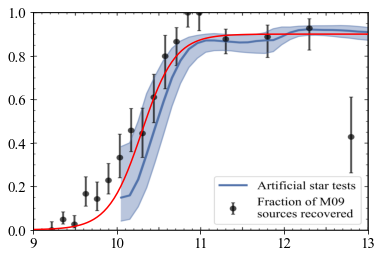

In [2]:
plt.imshow(plt.imread('selection_fraction.png'), extent=[9.,13.,0.,1.], aspect='auto')
kk=np.linspace(9.,13.,100)
plt.plot(kk,selection_function().Sk(kk,0.),color='r')

In [3]:
from data import load_mira_sample

from astropy.table import Table
mat = Table.read('matsunaga2009.vot').to_pandas()
mat = mat[mat['Per']>0.].reset_index(drop=True)
from data import add_spitzer_phot
mat_GG=add_spitzer_phot(mat, radeccols=['_RA','_DE'])
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=mat['_RA']*u.degree, dec=mat['_DE']*u.degree)
mat['l'] = c.galactic.l.deg
mat['b'] = c.galactic.l.deg

data = load_mira_sample(reliable=True, lowb=False)

s3d = schultheis_map_3d()

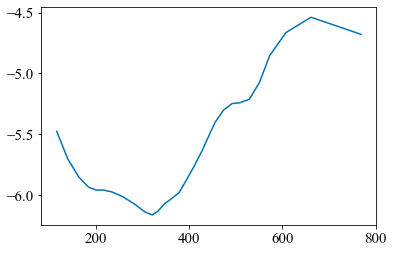

In [78]:
corrected_plr = plr(ks_c_rm[0])+(gaussian_filter1d(ks_c_rm[1],gbw,mode='nearest')-ks_c(ks_c_rm[0],c))*extC*c_i_ratio
plt.plot(ks_c_rm[0], corrected_plr)

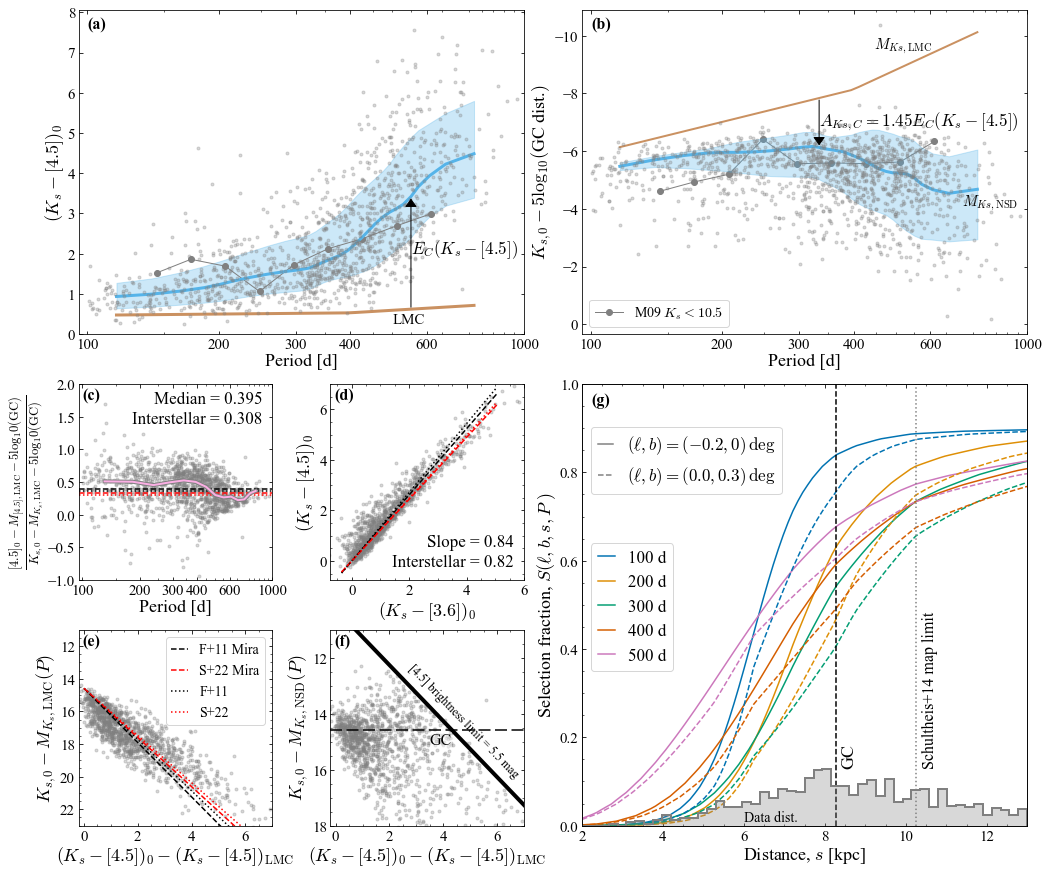

In [83]:
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_palette('colorblind')
from plotting_general import running_median, add_inner_ticks
from scipy.ndimage import gaussian_filter1d
from plotting import format_period_axis
from sklearn.linear_model import HuberRegressor

# Set up plotting grid
fig = plt.figure(figsize=(17, 15))
gs = GridSpec(4,4,height_ratios=[0.7,0.7,1.,1.])
ax1 = plt.subplot(gs[:2, :2])
ax2 = plt.subplot(gs[:2, 2:])
ax3 = plt.subplot(gs[2:, 2:])

ax_sub1 = plt.subplot(gs[2, 0])
ax_sub2 = plt.subplot(gs[2, 1])
ax_sub3 = plt.subplot(gs[3, 0])
ax_sub4 = plt.subplot(gs[3, 1])

plt.subplots_adjust(wspace=0.3,hspace=0.3)

# Extinction coefficients at representative wavelengths
ext_coeffs = dict(zip(model_grid.grid_orich.filters.filters['FilterID'],
                 model_grid.grid_orich.extC.extlaw_int(model_grid.grid_orich.filters.filters['λref']/10000.)))
ext_coeffs_S = dict(zip(model_grid_S.grid_orich.filters.filters['FilterID'],
                 model_grid_S.grid_orich.extC.extlaw_int(model_grid.grid_orich.filters.filters['λref']/10000.)))
gbw=1.5 # Gaussian blur width

include_correction = True

which = 'S-Rep'

c='4_5'
c_data = c
if c=='H':
    c_data = 'H_mean_model'
    matC = mat['Hmag']
else:
    matC = mat_GG[c]
# Extinction coefficient using model grid with Fritz extinction law
extC_F_model = model_grid.grid_orich.extC.median('Ks')/(model_grid.grid_orich.extC.median('Ks')-model_grid.grid_orich.extC.median(c))
HKcoeff_F_model = model_grid.grid_orich.extC.median('Ks')/(model_grid.grid_orich.extC.median('H')-model_grid.grid_orich.extC.median('Ks'))
# Extinction coefficient using model grid with Sanders extinction law
extC_S_model = model_grid_S.grid_orich.extC.median('Ks')/(model_grid_S.grid_orich.extC.median('Ks')-model_grid_S.grid_orich.extC.median(c))
HKcoeff_S_model = model_grid_S.grid_orich.extC.median('Ks')/(model_grid_S.grid_orich.extC.median('H')-model_grid_S.grid_orich.extC.median('Ks'))
# Fritz extinction at representative wavelengths
extC_F_rep = (ext_coeffs['Ks'])/(ext_coeffs['Ks']-ext_coeffs[c])
HKcoeff_F_rep = ext_coeffs['Ks']/(ext_coeffs['H']-ext_coeffs['Ks'])
# Sanders extinction at representative wavelengths
extC_S_rep = (ext_coeffs_S['Ks'])/(ext_coeffs_S['Ks']-ext_coeffs_S[c])
HKcoeff_S_rep = ext_coeffs_S['Ks']/(ext_coeffs_S['H']-ext_coeffs_S['Ks'])

if which=='F-Rep':
    extC = extC_F_rep
    HKcoeff = HKcoeff_F_rep
elif which=='F-Model':
    extC = extC_F_model
    HKcoeff = HKcoeff_F_model
elif which=='S-Rep':
    extC = extC_S_rep
    HKcoeff = HKcoeff_S_rep
elif which=='S-Model':
    extC = extC_S_model
    HKcoeff = HKcoeff_S_model

if c=='4_5':
    comparison = 'W2_mean_model'
elif c=='3_6':
    comparison = 'W1_mean_model'

RMM=running_median(data['period'],data[comparison]-data[c_data],nbins=15,equal_counts=True)
multiepoch_scatter = interp1d(RMM[0],gaussian_filter1d(.5*(RMM[3]-RMM[2]),2.,mode='nearest'),fill_value='extrapolate',bounds_error=False)

ext_multiplier = 1. # arbitrary extinction multiplier 
dist_assumed = 8.275 # assumed distance to the Galactic centre
with_ext = True # whether to include extinction in the model
c_i_ratio = 1.0

ext_ks = HKcoeff*with_ext*s3d.query(data['l'].values,data['b'].values, np.ones(len(data))*dist_assumed)
ext_ks_spread = HKcoeff*with_ext*s3d.query_spread(data['l'].values,data['b'].values, np.ones(len(data))*dist_assumed)
ext_ks_c = ext_ks/extC

nbins=30
min_dist, max_dist = 8.275-2.0, 8.275+2.0 # distance range to consider for extinction scatter
ext_width_ks_c = np.hypot(ext_ks_spread,
                     .5*(HKcoeff*with_ext*s3d.query(data['l'].values,data['b'].values,np.ones(len(data))*max_dist)-
                         HKcoeff*with_ext*s3d.query(data['l'].values,data['b'].values,np.ones(len(data))*min_dist)))/extC
rext_width_ks_c = running_median(data['period'], ext_width_ks_c, equal_counts=True,nbins=nbins)

ks_c_rm=running_median(data['period'], (data['Ks_mean_model']-data[c_data]) - ext_ks_c,
                       equal_counts=True,nbins=nbins)
corrected_plr = plr(ks_c_rm[0])+(gaussian_filter1d(ks_c_rm[1],gbw,mode='nearest')-ks_c(ks_c_rm[0],c))*extC*c_i_ratio
corrected_plr_width_2 = ((.5*(gaussian_filter1d(ks_c_rm[2],gbw,mode='nearest')-gaussian_filter1d(ks_c_rm[3],gbw,mode='nearest')))**2
                             -rext_width_ks_c[1]**2
                             -multiepoch_scatter(ks_c_rm[0])**2)*(extC*c_i_ratio)**2

def min_fn_spread_sqrt(k, min_val=0.13):
    KK = k.copy()
    KK[(KK<min_val**2)|(KK!=KK)] = min_val**2
    return np.sqrt(KK)

def plr_nsd(PP):
    return interp1d(ks_c_rm[0],corrected_plr,fill_value='extrapolate',bounds_error=False)(PP)
def width_plr_nsd(PP):
    return interp1d(ks_c_rm[0],min_fn_spread_sqrt(corrected_plr_width_2),
                    fill_value='extrapolate',bounds_error=False)(PP)

import pandas as pd
pd.DataFrame({'period':ks_c_rm[0],
              'plr':corrected_plr,
              'plr_width':min_fn_spread_sqrt(corrected_plr_width_2)}).to_csv('selection_function.csv',index=False)

if include_correction:
    SF = selection_function(plr=plr_nsd, width=width_plr_nsd)
else:
    SF = selection_function()

## Plot (Ks-c)_0 vs logP
## ---------------------
plt.sca(ax1)
# data
plt.plot(np.log10(data['period']), (data['Ks_mean_model']-data[c_data])-ext_ks_c,
         '.',alpha=0.3,color='gray',zorder=10,rasterized=True)
# Plot running median
plt.plot(np.log10(ks_c_rm[0]), gaussian_filter1d(ks_c_rm[1],gbw,mode='nearest'), 
         '-',lw=3, color=sns.color_palette('colorblind')[9])
# scatter
plt.fill_between(np.log10(ks_c_rm[0]), gaussian_filter1d(ks_c_rm[2],gbw,mode='nearest'),  
                 gaussian_filter1d(ks_c_rm[3],gbw,mode='nearest'), alpha=0.3, zorder=-10,
                 color=sns.color_palette('colorblind')[9])
# LMC relation
plt.plot(np.log10(ks_c_rm[0]), ks_c(ks_c_rm[0],c), '-',lw=3, color=sns.color_palette('colorblind')[5])
plt.annotate('LMC', xy=(2.7,0.2), xycoords='data', fontsize=15, ha='left', va='bottom')
# Plot Matsunaga+2009 data
fltr_mat = (mat['Ksmag']<10.5)&(mat['Kamp']>0.4)
rMat = running_median(np.log10(np.float64(mat['Per'].values))[fltr_mat],
((mat['Ksmag']-matC)-HKcoeff*with_ext*s3d.query(mat['l'].values,mat['b'].values,np.ones(len(mat))*dist_assumed)/extC)[fltr_mat],nbins=10)
plt.plot(rMat[0], rMat[1], 'o-', color='gray', lw=1, zorder=-3)
# Add arrow showing residual
plt.annotate('', xy=(np.log10(ks_c_rm[0])[-5],gaussian_filter1d(ks_c_rm[1],gbw,mode='nearest')[-5]), xycoords='data', 
             xytext=(np.log10(ks_c_rm[0])[-5],ks_c(ks_c_rm[0],c)[-5]), textcoords='data',
            arrowprops=dict(arrowstyle="-|>, head_width=0.5,head_length=0.7",connectionstyle="arc3",color='k'),zorder=50)
plt.annotate(r'$E_C(K_s-[4.5])$',xy=(np.log10(ks_c_rm[0])[-5],2.),fontsize=17)
# Formatting
cs = c.replace('_','.')
plt.ylabel(rf'$(K_s - [{cs}])_0$')
plt.ylim(0.,)
format_period_axis(with_secondary_axis=False)

# Plot Ks0 vs logP
# ----------------
plt.sca(ax2)
# NSD PLR
plt.plot(np.log10(ks_c_rm[0]), corrected_plr, zorder=10, lw=3, color=sns.color_palette('colorblind')[9])
plt.fill_between(np.log10(ks_c_rm[0]),
corrected_plr-min_fn_spread_sqrt(((gaussian_filter1d(ks_c_rm[2],gbw,mode='nearest')-gaussian_filter1d(ks_c_rm[1],gbw,mode='nearest'))**2
                                    -rext_width_ks_c[1]**2
                                    -multiepoch_scatter(ks_c_rm[0])**2)*(extC*c_i_ratio)**2),
corrected_plr+min_fn_spread_sqrt(((gaussian_filter1d(ks_c_rm[3],gbw,mode='nearest')-gaussian_filter1d(ks_c_rm[1],gbw,mode='nearest'))**2
                                    -rext_width_ks_c[1]**2
                                    -multiepoch_scatter(ks_c_rm[0])**2)*(extC*c_i_ratio)**2),
color=sns.color_palette('colorblind')[9],alpha=0.3,zorder=1)

# LMC relation
plt.plot(np.log10(ks_c_rm[0]), plr(ks_c_rm[0]), lw=2,zorder=2, color=sns.color_palette('colorblind')[5])
# labels
plt.annotate(r'$M_{Ks,\mathrm{LMC}}$', xy=(2.65,-9.3), xycoords='data', fontsize=15, ha='left', va='bottom')
plt.annotate(r'$M_{Ks,\mathrm{NSD}}$', xy=(2.85,corrected_plr[-2]), xycoords='data', fontsize=15, ha='left', va='top')
plt.annotate('', xy=(np.log10(ks_c_rm[0])[-18],corrected_plr[-18]), 
             xycoords='data', 
             xytext=(np.log10(ks_c_rm[0])[-18],plr(ks_c_rm[0])[-18]), textcoords='data',
            arrowprops=dict(arrowstyle="-|>, head_width=0.5,head_length=0.7",connectionstyle="arc3",color='k'),zorder=30)
plt.annotate(r'$A_{Ks,C}=%0.2fE_C(K_s-[4.5])$'%extC,xy=(np.log10(ks_c_rm[0])[-18],-6.9),fontsize=17)
# data
plt.plot(np.log10(data['period']), data['Ks_mean_model']-ext_ks-5*np.log10(dist_assumed*100.), 
         '.',alpha=0.3,color='gray',zorder=10,rasterized=True)
# Matsunaga+2009 data
rMat = running_median(np.log10(np.float64(mat['Per'].values))[fltr_mat],
((mat['Ksmag'])-HKcoeff*with_ext*s3d.query(mat['l'].values,mat['b'].values,np.ones(len(mat))*dist_assumed)
-5*np.log10(dist_assumed*100.))[fltr_mat],nbins=10)
plt.plot(rMat[0], rMat[1], 'o-', color='gray', lw=1, zorder=-3,label='M09 $K_s<10.5$')
plt.legend(loc='lower left')
# Formatting
plt.ylabel(r'$K_{s,0}-5\log_{10}($GC dist.$)$')
plt.gca().invert_yaxis()
format_period_axis(with_secondary_axis=False)

# Plot period against ratio of residuals
plt.sca(ax_sub1)
plt.plot(np.log10(data['period']), 
(data[c_data]-ext_ks*(1-1./extC)-(plr(data['period'])-ks_c(data['period'],c))-5.*np.log10(dist_assumed*100.))/
(data['Ks_mean_model']-ext_ks-plr(data['period'])-5.*np.log10(dist_assumed*100.)),
         '.',alpha=0.3,color='gray',rasterized=True)
rr_ratio = running_median(data['period'],
(data[c_data]-ext_ks*(1-1./extC)-(plr(data['period'])-ks_c(data['period'],c))-5.*np.log10(dist_assumed*100.))/
(data['Ks_mean_model']-ext_ks-plr(data['period'])-5.*np.log10(dist_assumed*100.)))
plt.annotate(f'Median = {np.nanmedian(rr_ratio[1]):.3f}',(0.95,0.9),xycoords='axes fraction',fontsize=17,ha='right')
plt.annotate(f'Interstellar = {-(1./extC-1):.3f}',(0.95,0.8),xycoords='axes fraction',fontsize=17,ha='right')
plt.plot(np.log10(rr_ratio[0]),rr_ratio[1],color='gray',lw=4,zorder=29)
plt.plot(np.log10(rr_ratio[0]),rr_ratio[1],color=sns.color_palette('colorblind')[6],lw=2,zorder=30)
plt.ylim(-1.,2.)
plt.axhline((1-1./extC_F_model),color='k',ls='--')
plt.axhline((1-1./extC_S_model),color='r',ls='--')
plt.axhline((1-1./extC_F_rep),color='k',ls=':')
plt.axhline((1-1./extC_S_rep),color='r',ls=':')
plt.xlabel('Period [d]')
plt.ylabel(r'$\frac{[4.5]_{0}-M_{[4.5],\mathrm{LMC}}-5\log_10(\mathrm{GC})}{K_{s,0}-M_{K_s,\mathrm{LMC}}-5\log_10(\mathrm{GC})}$')
format_period_axis(with_secondary_axis=False)

plt.sca(ax_sub3)
plt.plot((data['Ks_mean_model']-data[c_data])-ext_ks_c-ks_c(data['period'],c),
         (data['Ks_mean_model'])-ext_ks-plr(data['period']),
         '.',alpha=0.3,color='gray',rasterized=True)
xx = np.linspace(0.,10.)
plt.plot(xx,xx*extC_F_model+5.*np.log10(827.5),'k--',label='F+11 Mira')
plt.plot(xx,xx*extC_S_model+5.*np.log10(827.5),'r--',label='S+22 Mira')
plt.plot(xx,xx*extC_F_rep+5.*np.log10(827.5),'k:',label='F+11')
plt.plot(xx,xx*extC_S_rep+5.*np.log10(827.5),'r:',label='S+22')
if c_i_ratio!=1.:
    plt.plot(xx, xx*extC*c_i_ratio+5.*np.log10(827.5))
plt.legend(loc='upper right',handlelength=1.2)
plt.xlim(-0.2,7.)
plt.ylim(11.,23.)
plt.gca().invert_yaxis()
plt.xlabel(r'$(K_s-[4.5])_0-(K_s-[4.5])_\mathrm{LMC}$')
plt.ylabel(r'$K_{s,0}-M_{K_s,\mathrm{LMC}}(P)$')
add_inner_ticks()

plt.sca(ax_sub4)
plt.plot((data['Ks_mean_model']-data[c_data])-ext_ks_c-ks_c(data['period'],c),
         (data['Ks_mean_model'])-ext_ks-plr_nsd(data['period']),
         '.',alpha=0.3,color='gray',rasterized=True)
ppp = np.linspace(600.,800.)
c_mag_limit = 5.5
Xlim=[np.nanmedian((k-c_mag_limit)-ks_c(ppp,'4_5')-np.nanmedian(ext_ks_c)) for k in [10,11,12,13,14]]
Ylim=[np.nanmedian(k-plr_nsd(ppp)-np.nanmedian(ext_ks)) for k in [10,11,12,13,14]]
hh=HuberRegressor().fit(np.array(Xlim).reshape(-1,1),np.array(Ylim))
plt.plot(xx,hh.coef_*xx+hh.intercept_,color='k',lw=4)
l=plt.axhline(5.*np.log10(827.5),ls='--',color='k')
l.set_dashes([8,3])
t=plt.annotate('GC',xy=(3.5,15.1),rotation=0,fontsize=16)
t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='none',pad=0.))
plt.xlim(-0.2,7.)
plt.ylim(11.,18.)
plt.gca().invert_yaxis()
plt.xlabel(r'$(K_s-[4.5])_0-(K_s-[4.5])_\mathrm{LMC}$')
plt.ylabel(r'$K_{s,0}-M_{K_s,\mathrm{NSD}}(P)$')
plt.annotate('[4.5] brightness limit = 5.5 mag',xy=(2.6,hh.coef_*2.6+hh.intercept_+3.4),rotation=-46,fontsize=12)
add_inner_ticks()

xx = np.linspace(100.,1000.)
[plt.plot(
    np.nanmedian(k-plr_nsd(xx)-np.nanmedian(ext_ks)),
    np.nanmedian((k-c_mag_limit)-ks_c(xx,'4_5')-np.nanmedian(ext_ks_c))
    ,'b.') for k in [10,11,12,13,14]]

plt.sca(ax_sub2)

c1 = '3_6'
c2 = '4_5'
if c1=='H':
    c1_data = 'H_mean_model'
elif c1=='J':
    c1_data = 'J_mean_model'
else:
    c1_data = c1
if c2=='H':
    c2_data = 'H_mean_model'
elif c2=='J':
    c2_data = 'J_mean_model'
else:
    c2_data = c2

ext_coeff_c1_F = model_grid.grid_orich.extC.median('Ks')/(model_grid.grid_orich.extC.median('Ks')-model_grid.grid_orich.extC.median(c1))
ext_coeff_c2_F = model_grid.grid_orich.extC.median('Ks')/(model_grid.grid_orich.extC.median('Ks')-model_grid.grid_orich.extC.median(c2))
ext_coeff_c1_S = model_grid_S.grid_orich.extC.median('Ks')/(model_grid_S.grid_orich.extC.median('Ks')-model_grid_S.grid_orich.extC.median(c1))
ext_coeff_c2_S = model_grid_S.grid_orich.extC.median('Ks')/(model_grid_S.grid_orich.extC.median('Ks')-model_grid_S.grid_orich.extC.median(c2))

ext_coeff_c1_F_rep = ext_coeffs['Ks']/(ext_coeffs['Ks']-ext_coeffs[c1])
ext_coeff_c2_F_rep = ext_coeffs['Ks']/(ext_coeffs['Ks']-ext_coeffs[c2])
ext_coeff_c1_S_rep = ext_coeffs_S['Ks']/(ext_coeffs_S['Ks']-ext_coeffs_S[c1])
ext_coeff_c2_S_rep = ext_coeffs_S['Ks']/(ext_coeffs_S['Ks']-ext_coeffs_S[c2])

ext_ratio_F_model = (model_grid.grid_orich.extC.median('Ks')-model_grid.grid_orich.extC.median(c1))/(model_grid.grid_orich.extC.median('Ks')-model_grid.grid_orich.extC.median(c2))
ext_ratio_S_model = (model_grid_S.grid_orich.extC.median('Ks')-model_grid_S.grid_orich.extC.median(c1))/(model_grid_S.grid_orich.extC.median('Ks')-model_grid_S.grid_orich.extC.median(c2))
ext_ratio_F_rep = (ext_coeffs['Ks']-ext_coeffs[c1])/(ext_coeffs['Ks']-ext_coeffs[c2])
ext_ratio_S_rep = (ext_coeffs_S['Ks']-ext_coeffs_S[c1])/(ext_coeffs_S['Ks']-ext_coeffs_S[c2])

ext_coeff_c1 = ext_coeff_c1_S_rep
ext_coeff_c2 = ext_coeff_c2_S_rep

XX, YY = (data['Ks_mean_model']-data[c1_data])\
         -ext_ks/ext_coeff_c1\
            -ks_c(data['period'],c1),\
         (data['Ks_mean_model']-data[c2_data])\
         -ext_ks/ext_coeff_c2\
         -ks_c(data['period'],c2)
fltr = (np.abs(data['b'])>0.)
plt.plot(XX[fltr],YY[fltr],
         '.',alpha=0.3,color='gray',rasterized=True)
xx = np.linspace(np.nanpercentile(XX,0.5),np.nanpercentile(XX,99.5),100)
plt.plot(xx,xx/ext_ratio_F_model,'k--')
plt.plot(xx,xx/ext_ratio_S_model,'r--')
plt.plot(xx,xx/ext_ratio_F_rep,'k:')
plt.plot(xx,xx/ext_ratio_S_rep,'r:')
hh=HuberRegressor().fit(np.array(XX[(XX==XX)&(YY==YY)])[:,np.newaxis],YY[(XX==XX)&(YY==YY)])
plt.annotate(f'Slope = {1./hh.coef_[0]:.2f}',xy=(0.95,0.15),xycoords='axes fraction',ha='right',va='bottom',fontsize=17)
plt.annotate(f'Interstellar = {ext_ratio_S_model:.2f}',xy=(0.95,0.05),xycoords='axes fraction',ha='right',va='bottom',fontsize=17)
plt.xlabel(r'$(K_s-[3.6])_0$')
plt.ylabel(r'$(K_s-[4.5])_0$')
plt.xlim(-0.75,6.)
plt.ylim(-0.75,7.)
add_inner_ticks()

plt.sca(ax3)
ss = np.linspace(2.,14.,100)
l,b,=-0.2,-0.
[plt.plot(ss, SF.S(l,b,ss,P), label='%.0f d'%P) for P in np.linspace(100.,500.,5)]
plt.gca().set_prop_cycle(None)
l,b,=0.,.3
[plt.plot(ss, SF.S(l,b,ss,P),ls='dashed') for P in np.linspace(100.,500.,5)]
# plt.semilogy()
plt.axvline(8.275, color='k', ls='--')
plt.ylim(0.,1.)

plt.axvline(10.25,color='gray',ls=':')
plt.xlim(2.,14.)
from plotting_general import add_inner_ticks
add_inner_ticks()

plt.annotate('GC', xy=(8.4,0.13), rotation=90, fontsize=18,va='bottom')
t=plt.annotate('Schultheis+14 map limit', xy=(10.4,0.13), rotation=90, fontsize=16,va='bottom')
t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='none'))
leg=plt.legend(handlelength=1,loc=(0.02,0.35),fontsize=17)
plt.gca().add_artist(leg)

plt.ylabel(r'Selection fraction, $S(\ell,b,s,P\;)$')
plt.xlabel(r'Distance, $s$ [kpc]')

h = [plt.plot([],[], color="gray", ls='solid')[0],plt.plot([],[], color="gray", ls='dashed')[0]]
plt.legend(handles=h, handlelength=0.9,loc=(0.02,0.75), 
           labels=[r'$(\ell,b)=(-0.2,0)\,\mathrm{deg}$',
                   r'$(\ell,b)=(0.0,0.3)\,\mathrm{deg}$'],fontsize=17)
plt.xlim(2.,13.)
# plt.savefig('plots/selection_function.pdf', bbox_inches='tight')

plt.sca(ax1)
plt.annotate('(a)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')
plt.sca(ax2)
plt.annotate('(b)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')
plt.sca(ax_sub1)
plt.annotate('(c)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')
plt.sca(ax_sub2)
plt.annotate('(d)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')
plt.sca(ax_sub3)
plt.annotate('(e)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')
plt.sca(ax_sub4)
plt.annotate('(f)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')
plt.sca(ax3)
plt.annotate('(g)',xy=(0.02,0.98),xycoords='axes fraction',fontsize=16,fontweight='bold',ha='left',va='top')


plt.twinx()
plt.hist((np.power(10.,0.2*((data['Ks_mean_model'])-ext_ks-plr_nsd(data['period']))-2)),
         range=[2,13],bins=50,histtype='stepfilled',color='gray',alpha=0.3);
plt.hist((np.power(10.,0.2*((data['Ks_mean_model'])-ext_ks-plr_nsd(data['period']))-2)),
         range=[2,13],bins=50,histtype='step',color='gray',lw=2);
plt.annotate('Data dist.', xy=(6.,1.), xycoords='data', ha='left', va='bottom', fontsize=14, color='k')
plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
plt.ylim(0.,400.)
plt.savefig('plots/selection_function.pdf', bbox_inches='tight')

Text(0, 0.5, 'Circumstellar $A_{[4.5]}$')

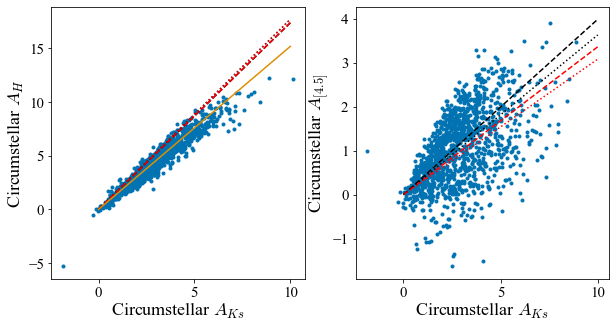

In [46]:
f,a=plt.subplots(1,2,figsize=[10,5])

plt.sca(a[0])
c='H'
extC_S_model = model_grid_S.grid_orich.extC.median(c)/model_grid_S.grid_orich.extC.median('Ks')
extC_F_model = model_grid.grid_orich.extC.median(c)/model_grid.grid_orich.extC.median('Ks')
extC_F_rep = ext_coeffs[c]/ext_coeffs['Ks']
extC_S_rep = ext_coeffs_S[c]/ext_coeffs_S['Ks']

HKcoeff = model_grid_S.grid_orich.extC.median('Ks')/(model_grid_S.grid_orich.extC.median('H')-model_grid_S.grid_orich.extC.median('Ks'))

plt.plot((data['Ks_mean_model'])-HKcoeff*with_ext*s3d.query(data['l'].values,data['b'].values, np.ones(len(data))*dist_assumed)-5.*np.log10(827.5)
-plr(data['period'].values),
(data['H_mean_model'])-(1./HKcoeff+1)*HKcoeff*with_ext*s3d.query(data['l'].values,data['b'].values, np.ones(len(data))*dist_assumed)-5.*np.log10(827.5)
-(-ks_c(data['period'].values,'H')+plr(data['period'].values)),'.')

xx = np.linspace(0.,10.)
plt.plot(xx,xx*extC_F_model,'k--',label='F+11 Mira')
plt.plot(xx,xx*extC_S_model,'r--',label='S+22 Mira')
plt.plot(xx,xx*extC_F_rep,'k:',label='F+11')
plt.plot(xx,xx*extC_S_rep,'r:',label='S+22')

plt.plot(xx, xx*1./0.66)

plt.xlabel(r'Circumstellar $A_{Ks}$')
plt.ylabel(r'Circumstellar $A_{H}$')


plt.sca(a[1])
c='4_5'
extC_S_model = model_grid_S.grid_orich.extC.median(c)/model_grid_S.grid_orich.extC.median('Ks')
extC_F_model = model_grid.grid_orich.extC.median(c)/model_grid.grid_orich.extC.median('Ks')
extC_F_rep = ext_coeffs[c]/ext_coeffs['Ks']
extC_S_rep = ext_coeffs_S[c]/ext_coeffs_S['Ks']

HKcoeff = model_grid_S.grid_orich.extC.median('Ks')/(model_grid_S.grid_orich.extC.median('H')-model_grid_S.grid_orich.extC.median('Ks'))

plt.plot((data['Ks_mean_model'])-HKcoeff*with_ext*s3d.query(data['l'].values,data['b'].values, np.ones(len(data))*dist_assumed)-5.*np.log10(827.5)
-plr(data['period'].values),
(data[c])-extC_S_model*HKcoeff*with_ext*s3d.query(data['l'].values,data['b'].values, np.ones(len(data))*dist_assumed)-5.*np.log10(827.5)
-(-ks_c(data['period'].values,'4_5')+plr(data['period'].values)),'.')

xx = np.linspace(0.,10.)
plt.plot(xx,xx*extC_F_model,'k--',label='F+11 Mira')
plt.plot(xx,xx*extC_S_model,'r--',label='S+22 Mira')
plt.plot(xx,xx*extC_F_rep,'k:',label='F+11')
plt.plot(xx,xx*extC_S_rep,'r:',label='S+22')

plt.xlabel(r'Circumstellar $A_{Ks}$')
plt.ylabel(r'Circumstellar $A_{[4.5]}$')

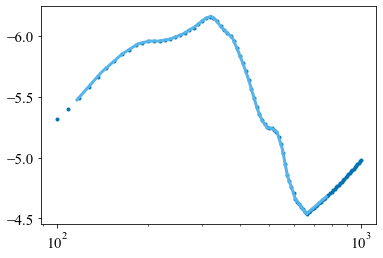

In [70]:
xx = np.linspace(100.,1000.,100)
plt.plot(xx, plr_nsd(xx), '.')
plt.semilogx()
plt.gca().invert_yaxis()
# NSD PLR
plt.plot(ks_c_rm[0], corrected_plr, zorder=10, lw=3, color=sns.color_palette('colorblind')[9])

In [ ]:
plt.plot((data['Ks_mean_model'])-HKcoeff*with_ext*s3d.query(data['l'].values,data['b'].values, np.ones(len(data))*dist_assumed)-5.*np.log10(827.5)
-plr(data['period'].values),
(data['H_mean_model'])-(1./HKcoeff+1)*HKcoeff*with_ext*s3d.query(data['l'].values,data['b'].values, np.ones(len(data))*dist_assumed)-5.*np.log10(827.5)
-(-ks_c(data['period'].values,'H')+plr(data['period'].values)),'.')

In [ ]:

## Wesenheit plot
# plt.plot(np.log10(data['period']), 
# data['Ks_mean_model']-extC*(data['Ks_mean_model']-data[c_data])
# -5.*np.log10(dist_assumed*100.),'.',alpha=0.2,color='gray')
# plt.plot(np.log10(ks_c_rm[0]), plr(ks_c_rm[0])-extC*ks_c(rr[0],c),color=sns.color_palette('colorblind')[5],lw=2,zorder=50)
# plt.annotate('LMC', xy=(np.log10(650.),-9.8), xycoords='data', fontsize=15, ha='left', va='bottom')

# format_period_axis(with_secondary_axis=False)
# plt.gca().invert_yaxis()
# plt.ylabel(rf'$K_s-{extC:.2f}(K_s-[{cs}])$')

/tmp/ipykernel_5028/1337648432.py:6: RuntimeWarning: overflow encountered in exp
  plt.plot(yy, [quad(lambda x: 1./(1.+np.exp(-x))*np.exp(-(xxx-x)**2/2./width**2)/np.sqrt(2.*np.pi*width**2), -np.inf, np.inf)[0] for xxx in yy])


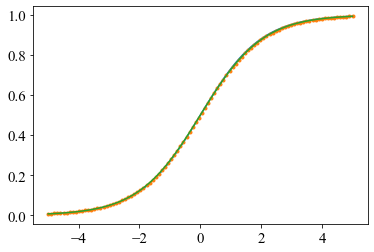

In [89]:
yy = np.linspace(-5.,5.,100)
import matplotlib.pyplot as plt
width = .3
plt.plot(yy, 1./(1.+np.exp(-yy)))
plt.plot(yy, C(width,yy), '.')
plt.plot(yy, [quad(lambda x: 1./(1.+np.exp(-x))*np.exp(-(xxx-x)**2/2./width**2)/np.sqrt(2.*np.pi*width**2), -np.inf, np.inf)[0] for xxx in yy])

(array([1.03e+03, 2.28e+02, 2.90e+01, 4.00e+00, 3.00e+00, 1.00e+00,
        1.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([0.00484635, 0.03579479, 0.06674324, 0.09769168, 0.12864012,
        0.15958856, 0.190537  , 0.22148544, 0.25243388, 0.28338232,
        0.31433076]),
 <BarContainer object of 10 artists>)

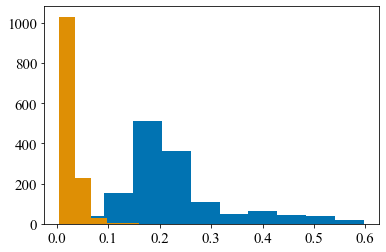

In [319]:
plt.hist(ext_width)
plt.hist(np.hypot(data['Ks_error_model'],data['e4_5']))

1.4990760237486658
1.4452586766319364
1.4452586766319364
Extinction map width??


/home/jls/work/mira/mira_nsd/selection_function.py:90: RuntimeWarning: overflow encountered in exp
  yy = np.array([[quad(lambda x: 1./(1.+np.exp(-x))*np.exp(-(xxx-x)**2/2./width**2)/np.sqrt(2.*np.pi*width**2), -np.inf, np.inf)[0] for xxx in xx]


Extinction map width??


(2.0, 13.0)

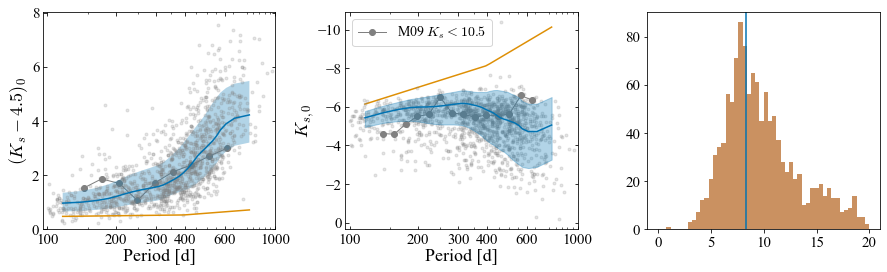

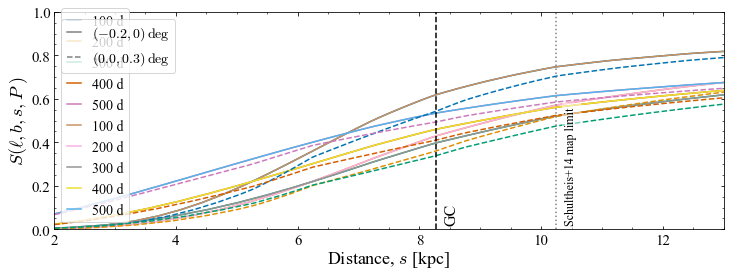

In [309]:
from plotting_general import running_median, add_inner_ticks
from scipy.ndimage import gaussian_filter1d
from plotting import format_period_axis

f,a=plt.subplots(1,3,figsize=(15,4),sharey=False)
plt.subplots_adjust(wspace=0.3)

gbw=2.
c='4_5'
c_data = c
if c=='H':
    c_data = 'H_mean_model'
extC = 1./(1-model_grid_S.grid_orich.extC.median(c))
print(extC)
extC = (ext_coeffs['Ks'])/(ext_coeffs['Ks']-ext_coeffs[c])
extC = (ext_coeffs_S['Ks'])/(ext_coeffs_S['Ks']-ext_coeffs_S[c])
print(extC)

plt.sca(a[0])
with_ext = True
min_dist, max_dist = 6.275, 10.275
dist_assumed = 8.275
c_i_ratio = 1.0
ext_width = np.hypot(1.328*with_ext*s3d.query_spread(data['l'].values,data['b'].values,np.ones(len(data))*dist_assumed),
                     .5*(1.328*with_ext*s3d.query(data['l'].values,data['b'].values,np.ones(len(data))*max_dist)-
                         1.328*with_ext*s3d.query(data['l'].values,data['b'].values,np.ones(len(data))*min_dist)))/extC

ks_c_rm=running_median(data['period'], (data['Ks_mean_model']-data[c_data])
         -1.328*with_ext*s3d.query(data['l'].values,data['b'].values,np.ones(len(data))*dist_assumed)/extC,
         equal_counts=True,nbins=30)
rext = running_median(data['period'], ext_width, equal_counts=True,nbins=30)
plt.plot(np.log10(data['period']), (data['Ks_mean_model']-data[c_data])-1.328*with_ext*s3d.query(data['l'].values,data['b'].values,
                                                                                                 np.ones(len(data))*dist_assumed)/extC,
                                                                                                 '.',alpha=0.2,color='gray')
plt.plot(np.log10(ks_c_rm[0]), gaussian_filter1d(ks_c_rm[1],gbw), '-')
plt.fill_between(np.log10(ks_c_rm[0]), gaussian_filter1d(ks_c_rm[2],gbw),  gaussian_filter1d(ks_c_rm[3],gbw), alpha=0.3)
plt.plot(np.log10(ks_c_rm[0]), ks_c(ks_c_rm[0],c), '-')
cs = c.replace('_','.')
plt.ylabel(rf'$(K_s - {cs})_0$')
# plt.semilogx()
plt.ylim(0.,)
format_period_axis(with_secondary_axis=False)

fltr_mat = (mat['Ksmag']<10.5)&(mat['Kamp']>0.4)
rMat = running_median(np.log10(np.float64(mat['Per'].values))[fltr_mat],
((mat['Ksmag']-matC)-HKcoeff*with_ext*s3d.query(mat['l'].values,mat['b'].values,np.ones(len(mat))*dist_assumed)/extC)[fltr_mat],nbins=10)
plt.plot(rMat[0], rMat[1], 'o-', color='gray', lw=1, zorder=-3)

plt.sca(a[1])
corrected_plr = plr(ks_c_rm[0])+(gaussian_filter1d(ks_c_rm[1],gbw)-ks_c(ks_c_rm[0],c))*extC*c_i_ratio
corrected_plr_u = plr(ks_c_rm[0])+(gaussian_filter1d(ks_c_rm[1],gbw)-ks_c(ks_c_rm[0],c))*extC
print(extC)
plt.plot(np.log10(ks_c_rm[0]), corrected_plr, color=sns.color_palette()[0], zorder=10)

plt.fill_between(np.log10(ks_c_rm[0]),
corrected_plr-np.sqrt((gaussian_filter1d(ks_c_rm[2],gbw)-gaussian_filter1d(ks_c_rm[1],gbw))**2-rext[1]**2)*extC*c_i_ratio,
corrected_plr+np.sqrt((gaussian_filter1d(ks_c_rm[3],gbw)-gaussian_filter1d(ks_c_rm[1],gbw))**2-rext[1]**2)*extC*c_i_ratio,
color=sns.color_palette()[0],alpha=0.3,zorder=10)

plt.plot(np.log10(ks_c_rm[0]), plr(ks_c_rm[0]), color=sns.color_palette()[1])

plt.plot(np.log10(data['period']), 
data['Ks_mean_model']-1.328*with_ext*s3d.query(data['l'].values,data['b'].values,np.ones(len(data))*dist_assumed)
-5*np.log10(dist_assumed*100.), '.', alpha=0.2, color='gray')

rMat = running_median(np.log10(np.float64(mat['Per'].values))[fltr_mat],
((mat['Ksmag'])-1.328*with_ext*s3d.query(mat['l'].values,mat['b'].values,np.ones(len(mat))*dist_assumed)
-5*np.log10(dist_assumed*100.))[fltr_mat])
plt.plot(rMat[0], rMat[1], 'o-', color='gray', lw=1, zorder=-3,label='M09 $K_s<10.5$')
plt.legend(loc='upper left')

plt.ylabel(r'$K_{s,0}$')

plt.gca().invert_yaxis()
format_period_axis(with_secondary_axis=False)

plt.sca(a[2])

def test_plr(PP):
    return interp1d(ks_c_rm[0],corrected_plr,fill_value='extrapolate',bounds_error=False)(PP)

plt.hist(np.power(10.,0.2*((data['Ks_mean_model'])-1.328*s3d.query(data['l'].values,data['b'].values,np.ones(len(data))*8.275)-test_plr(data['period']))-2),
         range=[0,20],bins=50,color=sns.color_palette('colorblind')[5]);
plt.axvline(8.3)


fig = plt.figure(figsize=(12,4))
import seaborn as sns
sns.set_palette('colorblind')

def test_plr(PP):
    return interp1d(ks_c_rm[0],corrected_plr,fill_value='extrapolate',bounds_error=False)(PP)
def test_plr2(PP):
    return interp1d(ks_c_rm[0],corrected_plr_u,fill_value='extrapolate',bounds_error=False)(PP)
def test_width(PP):
    return interp1d(ks_c_rm[0],np.sqrt((.5*(gaussian_filter1d(ks_c_rm[2],gbw)-ks_c(ks_c_rm[0],c)
                             -gaussian_filter1d(ks_c_rm[3],gbw)-ks_c(ks_c_rm[0],c)))**2-rext[1]**2)*extC,
                             fill_value='extrapolate',bounds_error=False)(PP)

SF_test = selection_function(plr=test_plr,width=test_width)
SF_test_u = selection_function(plr=test_plr2,width=test_width)

ss = np.linspace(2.,14.,100)
l,b,=-0.2,-0.
[plt.plot(ss, SF_test.S(l,b,ss,P), label='%.0f d'%P) for P in np.linspace(100.,500.,5)]
[plt.plot(ss, SF_test_u.S(l,b,ss,P), label='%.0f d'%P) for P in np.linspace(100.,500.,5)]
plt.gca().set_prop_cycle(None)
l,b,=0.,.3
[plt.plot(ss, SF_test.S(l,b,ss,P),ls='dashed') for P in np.linspace(100.,500.,5)]
# plt.semilogy()
plt.axvline(8.275, color='k', ls='--')
plt.ylim(0.,1.)

plt.axvline(10.25,color='gray',ls=':')
plt.xlim(2.,14.)
from plotting_general import add_inner_ticks
add_inner_ticks()

plt.annotate('GC', xy=(8.4,0.02), rotation=90, fontsize=16,va='bottom')
t=plt.annotate('Schultheis+14 map limit', xy=(10.4,0.02), rotation=90, fontsize=12,va='bottom')
t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='none'))
leg=plt.legend(handlelength=1,loc='lower left')
plt.gca().add_artist(leg)

plt.ylabel(r'$S(\ell,b,s,P\;)$')
plt.xlabel(r'Distance, $s$ [kpc]')

h = [plt.plot([],[], color="gray", ls='solid')[0],plt.plot([],[], color="gray", ls='dashed')[0]]
plt.legend(handles=h, handlelength=1,loc='upper left', 
           labels=[r'$(-0.2,0)\,\mathrm{deg}$',
                   r'$(0.0,0.3)\,\mathrm{deg}$'])
plt.xlim(2.,13.)
# plt.savefig('plots/selection_function.pdf', bbox_inches='tight')

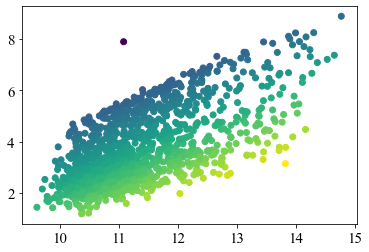

In [27]:
plt.scatter((data['Ks_mean_data']),(data['Ks_mean_data']-data['4_5']),c=data['4_5'])

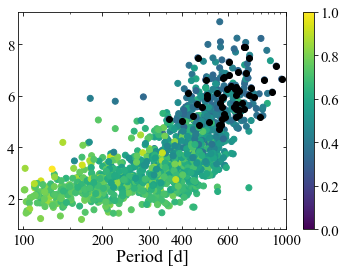

In [32]:
plt.scatter(np.log10(data['period']),(data['Ks_mean_data']-data['4_5']),c=data['4_5'])
fltr = (data['4_5']<5.7)
plt.scatter(np.log10(data['period'])[fltr],(data['Ks_mean_data']-data['4_5'])[fltr],color='k')
plt.colorbar()
format_period_axis(with_secondary_axis=False)

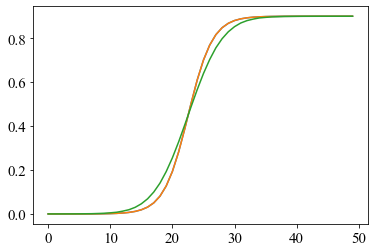

In [92]:
k=np.linspace(8.,13.)
plt.plot(.5*(1.-np.tanh((10.3-k)/.4))*.9)
plt.plot(.9/(1.+np.exp((10.3-k)/.2)))
plt.plot(.9*C(width/.2,(k-10.3)/.2))

/tmp/ipykernel_28327/3841871769.py:3: RuntimeWarning: overflow encountered in exp
  plt.plot(xx, [quad(lambda x: 1./(1.+np.exp(-x))*np.exp(-(xxx-x)**2/2./width**2)/np.sqrt(2.*np.pi*width**2), -np.inf, np.inf)[0] for xxx in xx],label='Convolution')


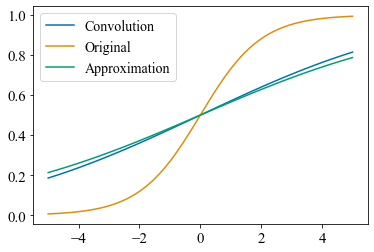

In [81]:
xx = np.linspace(-5,5,100)
width = 5.3
plt.plot(xx, [quad(lambda x: 1./(1.+np.exp(-x))*np.exp(-(xxx-x)**2/2./width**2)/np.sqrt(2.*np.pi*width**2), -np.inf, np.inf)[0] for xxx in xx],label='Convolution')
plt.plot(xx, 1./(1.+np.exp(-xx)),label='Original')
plt.plot(xx, 1./(1.+np.exp(-xx/np.sqrt(width**2+1.)*1.41)),label='Approximation')
plt.legend()

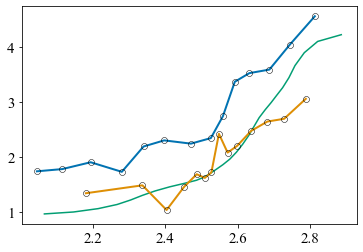

In [287]:

fltr = (mat['Ksmag']<10.5)
# plt.plot(np.log10(np.float64(mat['Per'].values))[fltr],
# ((mat['Ksmag']-mat_GG['4_5'])-1.328*with_ext*s3d.query(mat['l'].values,mat['b'].values,np.ones(len(mat))*dist_assumed)/extC)[fltr],'o',
#                                                                                                  mfc='none',mec='k',zorder=10,lw=0.1)

fltr = (mat['Ksmag']>10.5)
rm=running_median(np.log10(np.float64(mat['Per'].values))[fltr],
((mat['Ksmag']-mat_GG['4_5'])-1.328*with_ext*s3d.query(mat['l'].values,mat['b'].values,np.ones(len(mat))*dist_assumed)/extC)[fltr],equal_counts=True)
plt.plot(rm[0],rm[1],'o-',mfc='none',mec='k',zorder=10,lw=2,mew=0.5)

fltr = (mat['Ksmag']<10.5)
rm=running_median(np.log10(np.float64(mat['Per'].values))[fltr],
((mat['Ksmag']-mat_GG['4_5'])-1.328*with_ext*s3d.query(mat['l'].values,mat['b'].values,np.ones(len(mat))*dist_assumed)/extC)[fltr],equal_counts=True)
plt.plot(rm[0],rm[1],'o-',mfc='none',mec='k',zorder=10,lw=2,mew=0.5)

plt.plot(np.log10(ks_c_rm[0]), gaussian_filter1d(ks_c_rm[1],gbw), '-')

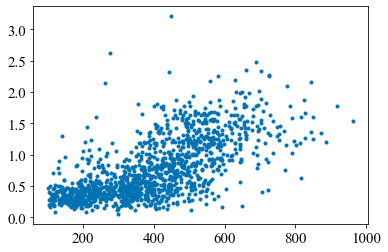

In [336]:
plt.plot(data['period'], data['W2_Ks_amplitude_ratio']*data['amplitude'],'.')

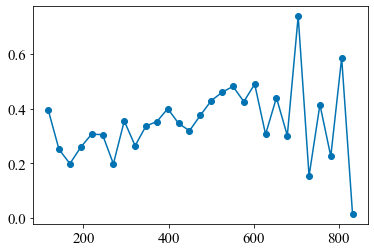

In [337]:
RMM=running_median(data['period'],data['W2_mean_model']-data['4_5'],nbins=30)
plt.plot(RMM[0],.5*(RMM[3]-RMM[2]),'o-')


(0.0, 10.0)

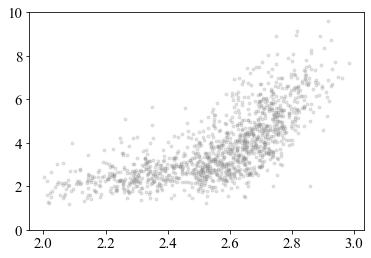

In [350]:
plt.plot(np.log10(data['period']), (data['Ks_mean_model']-data['W2_mean_model'])-1.328*with_ext*s3d.query(data['l'].values,data['b'].values,
                                                                                                 np.ones(len(data))*dist_assumed)/extC,
                                                                                                 '.',alpha=0.2,color='gray')
plt.ylim(0.,10.)